The DNN approach is suitable for project with a huge amount of data. Since both DDN approach and statistical approach with BGF and Gamma  (Lifetimes) perform with merely same results , we only need to choose which one suits us for the interface we are going to build. 

(I thought of a section in the interface which could be a radio button or a dropdown to choose between Statistical approach using Lifetimes (BGF and Gamma) versus DNN and compare the two but the blog says the results are merely the same and since we are not going to integrate Lifetimes we are just opting for DNN and Regression

### Necessary libraries to import

In [2]:
 pip install pandas-profiling

Note: you may need to restart the kernel to use updated packages.


"C:\Program" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [3]:
from pandas_profiling import ProfileReport

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# ML approach to LTV
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers

# evaluation
from sklearn.metrics import r2_score
from sklearn.metrics  import mean_absolute_error

# Plotting 
import matplotlib as plt
import seaborn as sns 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Data preprocessing and modeling (feature engineering)

       InvoiceNo StockCode                     Description  Quantity  \
16702     537666     84692     BOX OF 24 COCKTAIL PARASOLS         7   
281266    561515     23084              RABBIT NIGHT LIGHT         7   
440201    574514     21934              SKULL SHOULDER BAG         1   
67797     541846     22151       PLACE SETTING WHITE HEART        72   
222734    556459     21071  VINTAGE BILLBOARD DRINK ME MUG         2   

               InvoiceDate  UnitPrice  CustomerID         Country       date  \
16702  2010-12-07 18:36:00       0.85         NaN  United Kingdom 2010-12-07   
281266 2011-07-27 15:16:00       4.13         NaN  United Kingdom 2011-07-27   
440201 2011-11-04 13:34:00       1.65     15311.0  United Kingdom 2011-11-04   
67797  2011-01-23 12:43:00       0.42     13050.0  United Kingdom 2011-01-23   
222734 2011-06-10 17:25:00       2.46         NaN  United Kingdom 2011-06-10   

            time  hour  weekend  dayofweek  Revenue  
16702   18:36:00    18    False 

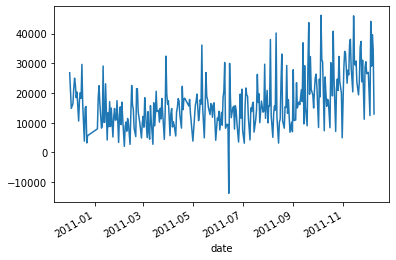

In [4]:
# Read the dataset 
data = pd.read_csv('../input/online-retail/Online-Retail.csv', engine='python')
data['InvoiceDate'] = pd.to_datetime(data.InvoiceDate, format = '%m/%d/%Y %H:%M')

#Datetime transformation
data['date'] = pd.to_datetime(data.InvoiceDate.dt.date)
data['time'] = data.InvoiceDate.dt.time
data['hour'] = data['time'].apply(lambda x: x.hour)
data['weekend'] = data['date'].apply(lambda x: x.weekday() in [5, 6])
data['dayofweek'] = data['date'].apply(lambda x: x.dayofweek)

#Get revenue column
data['Revenue'] = data['Quantity'] * data['UnitPrice']


print(data.sample(5))


#Plots a timeseries of total sales
data.groupby('date')['Quantity'].sum().plot()
#Prints the total number of days between start and end
print(data['date'].max() - data['date'].min())

In [5]:
#  Define the columns of interest
cols_of_interest = ['CustomerID', 'InvoiceDate', 'Revenue']
data = data[cols_of_interest]
print(data.head())
print('Number of entries: %s' % len(data))


   CustomerID         InvoiceDate  Revenue
0     17850.0 2010-12-01 08:26:00    15.30
1     17850.0 2010-12-01 08:26:00    20.34
2     17850.0 2010-12-01 08:26:00    22.00
3     17850.0 2010-12-01 08:26:00    20.34
4     17850.0 2010-12-01 08:26:00    20.34
Number of entries: 541909


In [6]:
#  To change the date format into details 
data['date'] = pd.to_datetime(data.InvoiceDate.dt.date)
data['time'] = data.InvoiceDate.dt.time
data['hour'] = data['time'].apply(lambda x: x.hour)
data['weekend'] = data['date'].apply(lambda x: x.weekday() in [5, 6])
data['dayofweek'] = data['date'].apply(lambda x: x.dayofweek)

In [7]:
data.sample(5)

,CustomerID,InvoiceDate,Revenue,date,time,hour,weekend,dayofweek
246248,14016.0,2011-07-01 11:29:00,25.50,2011-07-01,11:29:00,11,False,4
363016,16713.0,2011-09-27 13:49:00,3.75,2011-09-27,13:49:00,13,False,1
209654,13263.0,2011-06-01 15:34:00,3.30,2011-06-01,15:34:00,15,False,2
221879,13426.0,2011-06-10 09:23:00,20.00,2011-06-10,09:23:00,9,False,4
415721,NaN,2011-10-24 17:03:00,8.29,2011-10-24,17:03:00,17,False,0


In [8]:
# #  Context data for the revenue (date & customerID)
# id_lookup = data['CustomerID', 'InvoiceDate'].drop.duplicates()
# id_lookup.index = id_lookup['InvoiceDate']
# id_lookup = id_lookup.drop('InvoiceDate', axis=1)
# transaction_data = pd.DataFrame(data.groupby('InvoiceDate')['Revenue'].sum())


### DATA EXPLANATIONS
---Data gathered is for around one Year:ML approach needs time periods for featue creation, training targets,validation targets will be split according to the following segments: 
*   Training Features Period - from 2011-01-01 until 2011-06-11
*   Training Target Period - from 2011-06-12 until 2011-09-09
*   Testing Features Period - from 2011-04-02 until 2011-09-10
*   Testing Target Period - from 2011-09-11 until 2011-12-09


In [9]:
#Dataset info
print(f'Total Number of Purchases: {data.shape[0]}')
print(f'Total Number of transactions: {data.InvoiceDate.nunique()}')
print(f'Total Unique Days: {data.date.nunique()}')
print(f'Total Unique Customers: {data.CustomerID.nunique()}')
print(f"We are predicting {(data['date'].max() - datetime(2011, 9, 11)).days} days")

Total Number of Purchases: 541909
Total Number of transactions: 23260
Total Unique Days: 305
Total Unique Customers: 4372
We are predicting 89 days


In [10]:
#Generate the report. We would use the mpg dataset as sample, title parameter for naming our report, and explorative parameter set to True for Deeper exploration.
profile = ProfileReport(data, title='data Pandas Profiling Report')
profile

In [11]:
data.profile_report()

In [16]:
#  Feature engineering 
def get_features(data, feature_start, feature_end, target_start, target_end):
    """
    Function that outputs the features and targets on the user-level.
    Inputs:
        * data - a dataframe with raw data
        * feature_start - a string start date of feature period
        * feature_end - a  string end date of feature period
        * target_start - a  string start date of target period
        * target_end - a  string end date of target period
    """
    features_data = data.loc[(data.date >= feature_start) & (data.date <= feature_end), :]
    print(f'Using data from {(pd.to_datetime(feature_end) - pd.to_datetime(feature_start)).days} days')
    print(f'To predict {(pd.to_datetime(target_end) - pd.to_datetime(target_start)).days} days')
    
    #Transactions data features
    total_rev = features_data.groupby('CustomerID')['Revenue'].sum().rename('total_revenue')
    recency = (features_data.groupby('CustomerID')['date'].max() - features_data.groupby('CustomerID')['date'].min()).apply(lambda x: x.days).rename('recency')
    frequency = features_data.groupby('CustomerID')['InvoiceDate'].count().rename('frequency')
    t = features_data.groupby('CustomerID')['date'].min().apply(lambda x: (datetime(2011, 6, 11) - x).days).rename('t')
    time_between = (t / frequency).rename('time_between')
    avg_basket_value = (total_rev / frequency).rename('avg_basket_value')
    avg_basket_size = (features_data.groupby('CustomerID')['Quantity'].sum() / frequency).rename('avg_basket_Size')
    returns = features_data.loc[features_data['Revenue'] < 0, :].groupby('CustomerID')['InvoiceDate'].count().rename('num_returns')
    hour = features_data.groupby('CustomerID')['hour'].median().rename('purchase_hour_med')
    dow = features_data.groupby('CustomerID')['dayofweek'].median().rename('purchase_dow_med')
    weekend =  features_data.groupby('CustomerID')['weekend'].mean().rename('purchase_weekend_prop')
    train_data = pd.DataFrame(index = rfm_train.index)
    train_data = train_data.join([total_rev, recency, frequency, t, time_between, avg_basket_value, avg_basket_size, returns, hour, dow, weekend])
    train_data = train_data.fillna(0)
    
    #Target data
    target_data = data.loc[(data.date >= target_start) & (data.date <= target_end), :]
    target_quant = target_data.groupby(['CustomerID'])['date'].nunique()
    target_rev = target_data.groupby(['CustomerID'])['Revenue'].sum().rename('target_rev')
    train_data = train_data.join(target_rev).fillna(0)
    
    return train_data.iloc[:, :-1], train_data.iloc[:, -1]

#Dates are taken from the discussion above
X_train, y_train = get_features(data, '2011-01-01', '2011-06-11', '2011-06-12', '2011-09-09')
X_test, y_test = get_features(data, '2011-04-02', '2011-09-10', '2011-09-11', '2011-12-09')

print(X_train.head())

Using data from 161 days
To predict 89 days


KeyError: 'Column not found: Quantity'

In [17]:
#DNN
def build_model():
    model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[len(X_train.columns), ]),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae', 'mse'])
    
    return model

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_mse', patience=50)

model = build_model()
#Should take 10 sec
early_history = model.fit(X_train, y_train, 
                    epochs=1000, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])



NameError: name 'X_train' is not defined

In [ ]:

def evaluate(actual, sales_prediction):
    print(f"Total Sales Actual: {np.round(actual.sum())}")
    print(f"Total Sales Predicted: {np.round(sales_prediction.sum())}")
    print(f"Individual R2 score: {r2_score(actual, sales_prediction)} ")
    print(f"Individual Mean Absolute Error: {mean_absolute_error(actual, sales_prediction)}")
    plt.scatter(sales_prediction, actual)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')      
    plt.show()

#Predicting
dnn_preds = model.predict(X_test).ravel()

evaluate(y_test, dnn_preds)
